# 1.5 웹 검색을 지원하는 Corrective RAG

- [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다.


![corrective-rag](https://i.imgur.com/IzvmbWN.png)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'chroma_collection',
    persist_directory = './chroma_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str
    context: list
    answer: str


graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [6]:
from langchain_classic import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model="gpt-4o", max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    context = state["context"]
    query = state["query"]

    rag_chain = generate_prompt | generate_llm

    response = rag_chain.invoke({"question": query, "context": context})

    return {"answer": response.content}

- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단합니다
    - 문서와 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경합니다
        - `rewrite` 후 다시 `web_search` 노드로 이동해서 웹 검색을 합니다
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성합니다

In [7]:
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")


def check_doc_relevance(state: AgentState) -> Literal["relevant", "irrelvant"]:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state["query"]
    context = state["context"]

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question": query, "documents": context})

    if response["Score"] == 1:
        return "relevant"

    return "irrelvant"

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template(
    """사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
"""
)


def rewrite(state: AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query": query})

    return {"query": response}

- `web_search` 노드에서 웹 검색을 합니다
- `retrieve` 결과 대신 웹 검색 결과를 사용합니다
    - 웹 검색 결과는 [TavilySearchResults](https://tavily.com/) 툴을 사용합니다

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)


def web_search(state: AgentState) -> AgentState:
    query = state["query"]
    results = tavily_search_tool.invoke(query)

    return {"context": results}

/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/ipykernel_12587/782139084.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [10]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
# graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node("web_search", web_search)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges(
    "retrieve", check_doc_relevance, {"relevant": "generate", "irrelvant": "web_search"}
)
# graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge("web_search", "generate")
graph_builder.add_edge("generate", END)

In [12]:
graph = graph_builder.compile()

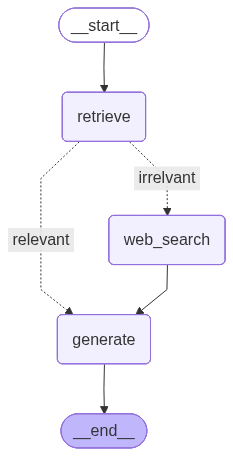

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {"query": "청년월세지원 신청인원은 몇명인가요?"}
graph.invoke(initial_state)

{'query': '청년월세지원 신청인원은 몇명인가요?',
 'context': [Document(id='0969859f-0fde-4b3f-a8d6-c0f378be360b', metadata={'source': './documents/청년월세지원.txt'}, page_content="2025년 서울시 청년월세지원 모집 공고\n서울시에서는 “서울특별시 청년주거 기본 조례 제7조”에 의거 청년의 주거비 부담 완화를 위해 다음과 같이 2025년 '서울시 청년월세지원 사업' 참여자를 모집하오니 많은 참여 바랍니다.\n2025년 6월 4일\n서울특별시장\n1. 사업 개요\n\n사업명: 2025년 서울시 청년월세지원 사업\n지원대상: 신청일 기준 서울시 월세 거주, 19세~39세 이하 청년 1인 가구\n  ※ 서울시 청년월세지원 기수혜자 및 국토교통부 청년희망시스템 특례지원 수혜 중인 자, '25년 자치구 자체 청년월세지원 사업(운평, 광진 등) 지원자로 선정된 사람은 지원 불가\n\n지원내용\n\n지원금액: 월 최대 20만원(최대 12개월/240만원) ※ 생애 1회  \n20만원 미만 월세 계약은 임대차계약서에 표기된 월세 금액만 지원(천원 단위 절삭 예시 차임) 108,000원 이상은 10만원 지원/ 관리비가 포함된 경우 관리비를 제외하고 월세만 지원\n서울형 주택바우처 수급자인 경우, 바우처 수급액을 제외한 차액 지급\n서울시 청년월세 지원 대상자 최종 선정 후 12개월간 지급\n\n신청접수\n\n신청기간: 2025. 6. 11.(수) 10:00 ~ 6. 24.(화) 18:00 (마감)\n신청인원: 15,000명\n신청방법: 서울주거포털 온라인 신청\n\n선정 및 지급\n\n선정방법: 임차보증금-월세 및 소득기준 4개 구간으로 나누어 선정하고 인원 초과시 구간별 전산 추첨\n지급방법: 각월 25일 전후로 계좌 입금\n지급일정: 10월(7월, 8월, 9월), 12월(10월, 11월분) 지급 이후, 잔여 7개월분은 '26년에 지급 예정 (※ 지급일정 변경 가능)\n※ 

In [15]:
initial_state = {"query": "역삼역 맛집을 추천해주세요"}
graph.invoke(initial_state)

{'query': '역삼역 맛집을 추천해주세요',
 'context': [{'title': '역삼역 맛집 총정리 도보 5분 맛집 리스트로 완전 정복! l feat. KSA ...',
   'url': 'https://www.youtube.com/watch?v=v7XRG4MoCXU',
   'content': '# 역삼역 맛집 총정리 🍲 도보 5분 맛집 리스트로 완전 정복! l feat. KSA 퓨처캠\n## KSA STORY\n17400 subscribers\n14 likes\n\n### Description\n1104 views\nPosted: 21 Apr 2025\n✨역삼역 맛집러들 주목! 역삼역 근처에서 점심 뭐 먹을지 고민 중이신가요?\n🎯역삼역 5분 거리 찐맛집 13곳을 소개합니다\n🍽 북어탕, 곰탕, 육개장부터 수제버거, 해물뚝배기, 곱창까지~\n\n🍀오늘 뭐 먹지 고민이 된다면? 이 영상 하나면 끝!\n📍역삼역에서 도보 3분 거리에는 한국표준협회 교육장도 있어요🤗\n\n1. 현대북어 : \n2. 이여곰탕 : \n3. 막 : \n4. 연가 : \n5. 이화수전통육개장 : \n6. 커피빈 : \n7. CU : \n\n00:00 인트로\n00:24 역삼역 찐맛집 소개 시작!\n00:27 현대북어 - 속이 확 풀리는 북어탕\n00:41 이여곰탕 - 서울 4대 곰탕\n00:54 막 - 겉바속촉 돈가스와 막국수 \n01:07 연가 - 한 상 가득 푸짐 백반\n01:21 이화수전통육개장 - 칼칼한 육개장\n01:34 커피빈한국표준협회교육센터점\n01:47 CU\n01:57 다른 맛집들도 있어요~!\n\n2 comments\n### Transcript:\nHeat. [Music] Heat. Heat up [Music] [Music] here. Heat. Heat. [Music] N. [Music] Heat. [Music] Heat. Heat. Heat. [Music] [Applause]',
   'score': 0.99966204,
   'raw_content'